In [1]:
import pandas as pd
import gzip
import json
import seaborn as sns
import numpy as np
import time
import html
import re
from tqdm import trange
import os
from typing import *
from tqdm import tqdm, trange
import urllib.request
from PIL import Image
import cv2 as cv
from matplotlib import pyplot as plt

In [2]:
from tqdm import tqdm
tqdm.pandas()

In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

        
def getPandasDataFrame(path, limit=None):
    i = 0
    df = {}
    try:
        for d in tqdm(parse(path)):
            df[i] = d
            i += 1
            if limit is not None and i >= limit:
                break
    except KeyboardInterrupt:
        pass
    return pd.DataFrame.from_dict(df, orient='index')

In [7]:
%%time
meta_electronics = getPandasDataFrame('meta_Electronics.json.gz', limit=None)

786445it [12:38, 1037.12it/s]


Wall time: 12min 47s


In [92]:
meta_electronics.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Electronics, Camera &amp; Photo, Video Survei...",,[The following camera brands and models have b...,,Genuine Geovision 1 Channel 3rd Party NVR IP S...,[],,GeoVision,"[Genuine Geovision 1 Channel NVR IP Software, ...","[>#3,092 in Tools &amp; Home Improvement &gt; ...",[],Camera &amp; Photo,,"January 28, 2014",$65.00,0011300000,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,"[Electronics, Camera &amp; Photo]",,[This second edition of the Handbook of Astron...,,"Books ""Handbook of Astronomical Image Processi...",[0999470906],,33 Books Co.,[Detailed chapters cover these fundamental top...,"[>#55,933 in Camera &amp; Photo (See Top 100 i...","[0943396670, 1138055360, 0999470906]",Camera &amp; Photo,,"June 17, 2003",,0043396828,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,"[Electronics, eBook Readers &amp; Accessories,...",,[A zesty tale. (Publishers Weekly)<br /><br />...,,One Hot Summer,"[0425167798, 039914157X]",,Visit Amazon's Carolina Garcia Aguilera Page,[],"3,105,177 in Books (",[],Books,,,$11.49,0060009810,[],[],NaN
3,"[Electronics, eBook Readers & Accessories, eBo...",,[],,Hurray for Hattie Rabbit: Story and pictures (...,"[0060219521, 0060219580, 0060219394]",,Visit Amazon's Dick Gackenbach Page,[],"2,024,298 in Books (","[0060219521, 0060219475, 0060219394]",Books,,,.a-section.a-spacing-mini{margin-bottom:6px!im...,0060219602,[],[],NaN
4,"[Electronics, eBook Readers & Accessories, eBo...",,[&#8220;sex.lies.murder.fame. is brillllli&#82...,,sex.lies.murder.fame.: A Novel,[],,Visit Amazon's Lolita Files Page,[],"3,778,828 in Books (",[],Books,,,$13.95,0060786817,[],[],NaN


In [7]:
meta_electronics.iloc[0].imageURLHighRes

['https://images-na.ssl-images-amazon.com/images/I/411uoWa89KL.jpg']

### Загружаем одну фотографию

In [4]:
import io
import requests

In [5]:
import urllib
url = 'https://images-na.ssl-images-amazon.com/images/I/411uoWa89KL.jpg'
size = len('https://images-na.ssl-images-amazon.com/images/I/')
urllib.request.urlretrieve(url, 'images_0/' + url[size:])

('images_0/411uoWa89KL.jpg', <http.client.HTTPMessage at 0x1a58b3979a0>)

In [6]:
img = cv.imread('images_0/' + url[size:])

In [22]:
%%time
url = 'https://images-na.ssl-images-amazon.com/images/I/411uoWa89KL.jpg'
img_stream = io.BytesIO(requests.get(url).content)
img = cv.imdecode(np.frombuffer(img_stream.read(), np.uint8), 1)

Wall time: 163 ms


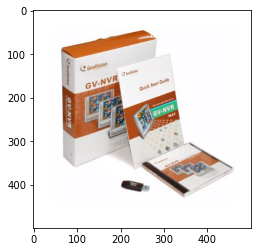

In [25]:
plt.imshow(img)
plt.show()

Проверяем multithreading

In [7]:
import urllib.request
from concurrent.futures import ThreadPoolExecutor

In [70]:
urls = list(meta_electronics.iloc[0:200].imageURLHighRes)

In [81]:
def get_image(urls):
    try:
        if len(urls) == 0:
            return None
        url = urls[0]
        img_stream = io.BytesIO(requests.get(url).content)
        img = cv.imdecode(np.frombuffer(img_stream.read(), np.uint8), 1)
        return img
    except Exception:
        return None

In [82]:
# %%time
# with ThreadPoolExecutor(4) as executor:
#     results = executor.map(get_image, urls)

In [8]:
import concurrent.futures

In [84]:
%%time
res = []
for url in tqdm.tqdm(urls):
    res.append(get_image(url))

100%|██████████| 200/200 [00:13<00:00, 14.77it/s]

Wall time: 13.8 s


In [85]:
%%time
with concurrent.futures.ThreadPoolExecutor(8) as executor:
     res = executor.map(get_image, urls)

Wall time: 1.69 s


In [86]:
%%time
with concurrent.futures.ThreadPoolExecutor(16) as executor:
     res = executor.map(get_image, urls)

Wall time: 1.34 s


__Вывод__: multithreading вполне нормально работает

### Подготовим датасет, перед тем, как загружать картинки

In [87]:
meta_electronics = meta_electronics.drop_duplicates('title')
meta_electronics.shape

(742022, 19)

In [88]:
def map_by_batches(df, func, batch_size = 2000):
    batch_results = []
    for i in trange(df.shape[0] // batch_size + 1):
        l = batch_size * i
        r = min(df.shape[0], l + batch_size)
        batch_results.append(func(df[l : r]))
    return pd.concat(batch_results)

In [93]:
def extract_rank_and_category(data):
    rank_str = re.compile(">#[\d,]* in ")
    
    ranks = []
    categories = []

    description = []
    title = []
    brand = []
    feature = []
    price = []
    images = []
    imagesHighRes = []
    asin = []

    def extract(string):
        result = rank_str.match(string)
        if not result:
            return -1, ""
        rank = result.group(0)[2:-4]
        category = string[result.span()[1]:] 
        return int(rank.replace(',', '')), html.unescape(category)
    try:
        for i in range(data.shape[0]):
            string = data.iloc[i]['rank']
            if not isinstance(string, str):
                if not string:
                    continue
                else:
                    string_list = string
                    for string in string_list:
                        rank, category = extract(string)
                        if rank == -1:
                            continue
                        ranks.append(rank)
                        categories.append(category)
                        description.append(data.iloc[i]['description'])
                        title.append(data.iloc[i]['title'])
                        brand.append(data.iloc[i]['brand'])
                        feature.append(data.iloc[i]['feature'])
                        price.append(data.iloc[i]['price'])
                        asin.append(data.iloc[i]['asin'])
                        images.append(data.iloc[i]['imageURL'])
                        imagesHighRes.append(data.iloc[i]['imageURLHighRes'])
            else:
                rank, category = extract(string)
                if rank == -1:
                    continue
                ranks.append(rank)
                categories.append(category)
                description.append(data.iloc[i]['description'])
                title.append(data.iloc[i]['title'])
                brand.append(data.iloc[i]['brand'])
                feature.append(data.iloc[i]['feature'])
                price.append(data.iloc[i]['price'])
                asin.append(data.iloc[i]['asin'])
                images.append(data.iloc[i]['imageURL'])
                imagesHighRes.append(data.iloc[i]['imageURLHighRes'])
    except KeyboardInterrupt:
        pass

    df = pd.DataFrame({'rank':np.array(ranks), 'category':np.array(categories), 
                                      'description':np.array(description), 'title':np.array(title),
                                      'brand':np.array(brand), 'feature':np.array(feature),
                                      'price':np.array(price),
                                      'asin': np.array(asin),
                                      'images': np.array(images),
                                      'imagesHighRes': np.array(imagesHighRes),
                                     }, dtype=object)
    return df

In [94]:
meta_electronics_with_prices = meta_electronics[meta_electronics['price'] != '']
meta_electronics_with_prices.shape

(291809, 19)

In [95]:
def simple_filter(df):
    df = df[df['price'] != '']
    df = df.drop_duplicates('title')
    print(df.shape)
    return df

In [100]:
%%time
meta_Arts_Crafts_and_Sewing = getPandasDataFrame('meta_Arts_Crafts_and_Sewing.json.gz', limit=None)
meta_Arts_Crafts_and_Sewing = simple_filter(meta_Arts_Crafts_and_Sewing)

302988it [01:22, 3683.56it/s]


(182572, 19)
Wall time: 1min 27s


In [101]:
meta_electronics_clear = map_by_batches(meta_electronics_with_prices, extract_rank_and_category, batch_size = 20000)

  0%|          | 0/15 [00:00<?, ?it/s]C:\Users\artyo\AppData\Local\Temp/ipykernel_8992/1701605967.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'description':np.array(description), 'title':np.array(title),
C:\Users\artyo\AppData\Local\Temp/ipykernel_8992/1701605967.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'brand':np.array(brand), 'feature':np.array(feature),
C:\Users\artyo\AppData\Local\Temp/ipykernel_8992/1701605967.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of list

In [102]:
meta_Arts_Crafts_and_Sewing = map_by_batches(meta_Arts_Crafts_and_Sewing, extract_rank_and_category, batch_size = 20000)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\artyo\AppData\Local\Temp/ipykernel_8992/1701605967.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'description':np.array(description), 'title':np.array(title),
C:\Users\artyo\AppData\Local\Temp/ipykernel_8992/1701605967.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'brand':np.array(brand), 'feature':np.array(feature),
C:\Users\artyo\AppData\Local\Temp/ipykernel_8992/1701605967.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of list

In [157]:
metadata_clear = pd.concat([meta_Arts_Crafts_and_Sewing, meta_electronics_clear])

In [10]:
import psutil, humanize

def mem_report():
    print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))

mem_report()

CPU RAM Free: 10.8 GB


In [159]:
metadata_clear.shape

(879794, 10)

In [160]:
metadata_clear.head()

,rank,category,description,title,brand,feature,price,asin,images,imagesHighRes
0,9616321,Home & Kitchen (See Top 100 in Home & Kitchen),[],Pinkie Tm girl flower Handmade soap silicone m...,,[],$35.00,7121277158,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
1,11120,"Arts, Crafts & Sewing > Craft Supplies > Soap ...",[],Pinkie Tm girl flower Handmade soap silicone m...,,[],$35.00,7121277158,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
2,1953912,Home & Kitchen (See Top 100 in Home & Kitchen),[],Pinkie Tm 3D blooming chrysanthemums Flower So...,,[],$35.00,7121280027,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
3,2574,"Arts, Crafts & Sewing > Craft Supplies > Soap ...",[],Pinkie Tm 3D blooming chrysanthemums Flower So...,,[],$35.00,7121280027,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,761776,Kitchen & Dining (See Top 100 in Kitchen & Din...,[moldsize:L7.2xW3.7xH4.8cm(L2.83xW1.46xH1.89in...,Pinkie Tm Rabbit animal silicone soap mold for...,pinkie,"[Made in 100% pure silicone,softness and comfo...",$7.99,7121281821,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [163]:
# ! pip install beautifulsoup4
from bs4 import BeautifulSoup

def get_filtered_sentence(sentence):
    cleantext = BeautifulSoup(str(sentence).replace("[", "").replace("'", "").replace("]", ""), "html.parser").text
    return cleantext

In [164]:
metadata_clear['description'] = metadata_clear['description'].progress_apply(lambda x: get_filtered_sentence(str(x)))

  0%|          | 2477/879794 [00:00<02:22, 6163.78it/s]C:\Users\artyo\anaconda3\lib\site-packages\bs4\__init__.py:337: MarkupResemblesLocatorWarning: "." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  warnings.warn(
  2%|▏         | 17448/879794 [00:02<01:44, 8273.95it/s]C:\Users\artyo\anaconda3\lib\site-packages\bs4\__init__.py:337: MarkupResemblesLocatorWarning: ". . . ." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  warnings.warn(
  5%|▌         | 44589/879794 [00:05<01:24, 9886.37it/s]C:\Users\artyo\anaconda3\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "https://www.amscan.com/graphics_cache/f/f/35858-210167-3-600.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed tha

In [165]:
metadata_clear['title'] = metadata_clear['title'].progress_apply(lambda x: get_filtered_sentence(str(x)))

100%|██████████| 879794/879794 [01:47<00:00, 8161.81it/s]


In [166]:
metadata_clear['feature'] = metadata_clear['feature'].progress_apply(lambda x: get_filtered_sentence(str(x)))

 30%|███       | 266056/879794 [00:42<01:47, 5716.18it/s]C:\Users\artyo\anaconda3\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "https://youtu.be/J5d25NmFVWI" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
 67%|██████▋   | 590604/879794 [01:39<00:38, 7557.71it/s]C:\Users\artyo\anaconda3\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "http://www.nvidia.com/content/grid/pdf/GRID_K2_BD-06580-001_v02.pdf" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
 70%|███████   | 616962/879794 [01:42<00:42, 6142.33it/s]C:\Users\artyo\anaconda3\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "http://www.twhouse.com/media/catal

In [167]:
metadata_clear['brand'] = metadata_clear['brand'].progress_apply(lambda x: get_filtered_sentence(str(x)))

 31%|███▏      | 276531/879794 [00:32<01:03, 9550.20it/s]C:\Users\artyo\anaconda3\lib\site-packages\bs4\__init__.py:346: MarkupResemblesLocatorWarning: "Aux" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
100%|██████████| 879794/879794 [01:54<00:00, 7700.74it/s]


In [168]:
from price_parser import Price

def parse_price(price):
    res = 0
    try:
        res = Price.fromstring(str(price)).amount_float
    except Exception:
        res = -1
    return res

In [169]:
metadata_clear['price'] = metadata_clear['price'].progress_apply(lambda x: parse_price(x))

100%|██████████| 879794/879794 [00:30<00:00, 29266.40it/s]


In [170]:
metadata_clear = metadata_clear.dropna()

In [171]:
metadata_clear.shape

(878653, 10)

Создаём уникальные id для категорий

In [172]:
categories_list = metadata_clear['category'].values.tolist()

In [173]:
len(set(categories_list))

2682

In [174]:
from collections import defaultdict
  
temp = defaultdict(lambda: len(temp))
categories_ids = [temp[ele] for ele in categories_list]
len(set(categories_ids))

2682

In [175]:
metadata_clear['category_id'] = np.array(categories_ids)

In [176]:
metadata_clear['rank'].describe()

count     878653
unique    316786
top            1
freq         448
Name: rank, dtype: int64

### Уберём очень большие ранги

In [177]:
metadata_clear = metadata_clear[metadata_clear['rank'] <= 1000000]

In [178]:
metadata_parsed = metadata_clear.copy()

In [179]:
metadata_parsed['rank'] = metadata_parsed['rank'].astype(float)

### Модели ранжирования в TF Ranking подразумевают, что чем больше скор, тем лучше, поэтому нужна функция, которая адекватно переводит ранги из отсортированных по возрастанию в отсортированные по убыванию, в идеале - ещё в небольшом диапавзоне, чтобы не было nan

In [180]:
metadata_parsed['rank_scaled'] = np.log10(metadata_parsed['rank'])

In [181]:
metadata_parsed.head()

,rank,category,description,title,brand,feature,price,asin,images,imagesHighRes,category_id,rank_scaled
1,11120.0,"Arts, Crafts & Sewing > Craft Supplies > Soap ...",,Pinkie Tm girl flower Handmade soap silicone m...,,,35.00,7121277158,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,1,4.046105
3,2574.0,"Arts, Crafts & Sewing > Craft Supplies > Soap ...",,Pinkie Tm 3D blooming chrysanthemums Flower So...,,,35.00,7121280027,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,1,3.410609
4,761776.0,Kitchen & Dining (See Top 100 in Kitchen & Din...,moldsize:L7.2xW3.7xH4.8cm(L2.83xW1.46xH1.89inc...,Pinkie Tm Rabbit animal silicone soap mold for...,pinkie,"Made in 100% pure silicone,softness and comfor...",7.99,7121281821,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,2,5.881827
5,636.0,"Arts, Crafts & Sewing > Craft Supplies > Ceram...",moldsize:L7.2xW3.7xH4.8cm(L2.83xW1.46xH1.89inc...,Pinkie Tm Rabbit animal silicone soap mold for...,pinkie,"Made in 100% pure silicone,softness and comfor...",7.99,7121281821,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,3,2.803457
7,7303.0,"Arts, Crafts & Sewing > Craft Supplies > Soap ...",,Pinkie Tm Womens Wallets handbag purse shaped ...,,,35.00,7121282534,[],[],1,3.863501


In [182]:
metadata_parsed['rank_scaled'].describe()

count    818780.000000
mean          4.139722
std           1.089932
min           0.000000
25%           3.392873
50%           4.195124
75%           4.989192
max           5.999997
Name: rank_scaled, dtype: float64

In [183]:
metadata_parsed['rank_scaled'] = -metadata_parsed['rank_scaled'] + metadata_parsed['rank_scaled'].max() 

In [184]:
metadata_parsed['rank_scaled'].describe()

count    818780.000000
mean          1.860274
std           1.089932
min           0.000000
25%           1.010805
50%           1.804872
75%           2.607124
max           5.999997
Name: rank_scaled, dtype: float64

In [185]:
df = metadata_parsed.groupby('category_id')['title'].count() > 40

In [186]:
df = df.reset_index()

In [187]:
category_ids = list(df[df['title'] == True].category_id)

In [188]:
metadata_parsed = metadata_parsed[metadata_parsed['category_id'].isin(category_ids)]

In [189]:
metadata_parsed.shape

(805088, 12)

In [191]:
%%time
metadata_parsed.to_csv('metadata_parsed_with_images.csv', index=False)

Wall time: 29.4 s


In [9]:
%%time
metadata_test = pd.read_csv('metadata_parsed_with_images.csv')

Wall time: 8.44 s


In [11]:
metadata_test.shape

(805088, 12)

In [12]:
metadata_test = metadata_test.fillna('')

In [13]:
import ast

In [14]:
%%time
metadata_test['images'] = metadata_test['images'].apply(lambda x: ast.literal_eval(x))

Wall time: 7.01 s


In [15]:
%%time
metadata_test['imagesHighRes'] = metadata_test['imagesHighRes'].apply(lambda x: ast.literal_eval(x))

Wall time: 7.33 s


In [16]:
part = metadata_test.iloc[0:1000]

In [17]:
urls = list(part.imagesHighRes)

In [22]:
import traceback
from functools import partial
def get_image(urls, path='images_0/'):
    import traceback
    import urllib.request
    try:
        if len(urls) == 0:
            return None
        url = urls[0]
        urllib.request.urlretrieve(url, path + url[49:])
    except Exception:
        print(f"Exception: {traceback.format_exc()}")
    return None

In [23]:
# ! pip install mapply

In [24]:
%%time
import pandas as pd
import mapply

mapply.init(
    n_workers=-1
)

_ = part.images.mapply(partial(get_image, path='images_0/'))

  0%|          | 0/10 [00:00<?, ?it/s]

Wall time: 9.21 s


In [25]:
metadata_test.shape

(805088, 12)

In [26]:
from tqdm import trange

In [29]:
mem_report()

CPU RAM Free: 9.9 GB


In [30]:
print('images high res')
part.imagesHighRes.mapply(partial(get_image, path=f'images_high_res_{i}/'))

images high res


  0%|          | 0/56 [00:00<?, ?it/s]

0        None
1        None
2        None
3        None
4        None
         ... 
99995    None
99996    None
99997    None
99998    None
99999    None
Name: imagesHighRes, Length: 100000, dtype: object

In [31]:
for i in trange(1, 8):
    l = i * 100000
    r = min(l + 100000, metadata_test.shape[0])
    print(f"[{l}:{r}]")
    mem_report()
    part = metadata_test.iloc[l:r]
    print('images')
    part.images.mapply(partial(get_image, path=f'images_{i}/'))
    print('images high res')
    part.imagesHighRes.mapply(partial(get_image, path=f'images_high_res_{i}/'))

  0%|          | 0/7 [00:00<?, ?it/s]

[100000:200000]
CPU RAM Free: 9.8 GB
images


  0%|          | 0/56 [00:00<?, ?it/s]

images high res


  0%|          | 0/56 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [48:27<4:50:45, 2907.59s/it]

[200000:300000]
CPU RAM Free: 9.0 GB
images


  0%|          | 0/56 [00:00<?, ?it/s]

images high res


  0%|          | 0/56 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [1:46:05<4:29:15, 3231.08s/it]

[300000:400000]
CPU RAM Free: 9.0 GB
images


  0%|          | 0/56 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [1:59:04<4:57:41, 3572.37s/it]


KeyboardInterrupt: 

In [71]:
def load_image(urls):
    import cv2 as cv
    try:
        if len(urls) == 0:
            return None
        url = urls[0]
        img = cv.imread('images/' + url[49:])
        return img
    except Exception:
        print(f"Exception: {traceback.format_exc()}")
        return False

In [72]:
part["loaded_images"] = part["images"].mapply(load_image)

  0%|          | 0/56 [00:00<?, ?it/s]

C:\Users\artyo\AppData\Local\Temp/ipykernel_12648/3717889991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part["loaded_images"] = part["images"].mapply(load_image)
